# Trabajar con series temporales

Pandas se desarrolló en el contexto de la modelización financiera, por lo que, como era de esperar, contiene un conjunto bastante amplio de herramientas para trabajar con fechas, horas y datos indexados en el tiempo.
Los datos de fecha y hora vienen en varias formas, que discutiremos aquí:

- Los *TimeStamp* hacen referencia a momentos particulares en el tiempo (por ejemplo, 4 de julio de 2015 a las 7:00am).
- Los *intervalos de tiempo* y los *períodos* hacen referencia a un periodo de tiempo entre un punto inicial y final concreto; por ejemplo, el año 2015. Los periodos suelen hacer referencia a un caso especial de intervalos de tiempo en el que cada intervalo tiene una longitud uniforme y no se solapa (por ejemplo, periodos de 24 horas que comprenden días).
- Los *deltas* o *duraciones* de tiempo hacen referencia a una longitud exacta de tiempo (por ejemplo, una duración de 22,56 segundos).

En este notebook, introduciremos cómo trabajar con cada uno de estos tipos de datos fecha/hora en Pandas.
Esta breve sección no es en absoluto una guía completa de las herramientas de series temporales disponibles en Python o Pandas, sino que pretende ser una visión general de cómo usted, debe abordar el trabajo con series temporales.
Comenzaremos con una breve discusión de las herramientas para tratar con fechas y horas en Python, antes de pasar más específicamente a una discusión de las herramientas proporcionadas por Pandas.

## Dates y Times en Python

El mundo Python dispone de un gran número de representaciones de fechas, horas, deltas y periodos de tiempo.
Aunque las herramientas de series temporales proporcionadas por Pandas tienden a ser las más útiles para aplicaciones de ciencia de datos, es útil ver su relación con otros paquetes utilizados en Python.

### Date y time nativas de Python: ``datetime`` y ``dateutil``

Los objetos básicos de Python para trabajar con fechas y horas residen en el módulo incorporado ``datetime``.
Junto con el módulo de terceros ``dateutil``, puedes utilizarlo para realizar rápidamente una serie de funciones útiles con fechas y horas.
Por ejemplo, puedes construir manualmente una fecha utilizando el tipo ``datetime``:

In [17]:
from datetime import datetime
datetime(year=2015, month=7, day=4)

datetime.datetime(2015, 7, 4, 0, 0)

O, utilizando el módulo ``dateutil``, puede analizar fechas a partir de diversos formatos de string:

In [18]:
from dateutil import parser
date = parser.parse("4th of July, 2015")
date

datetime.datetime(2015, 7, 4, 0, 0)

Una vez que tienes un objeto ``datetime``, puedes hacer cosas como imprimir el día de la semana:

In [19]:
date.strftime('%A')

'Saturday'

En la última línea, hemos usado uno de los códigos de formato de string estándar para imprimir fechas (``"%A"``), sobre el que puedes leer en la [sección strftime](https://docs.python.org/es/3/library/datetime.html#strftime-and-strptime-behavior) de la [documentación de datetime](https://docs.python.org/es/3/library/datetime.html) de Python.
La documentación de otras utilidades de fecha se puede encontrar en [dateutil's online documentation](http://labix.org/python-dateutil).

Un paquete relacionado que hay que tener en cuenta es [``pytz``](https://github.com/stub42/pytz/blob/master/src/README.rst), que contiene herramientas para trabajar con la parte de los datos de series temporales que más migra: las zonas horarias.

La potencia de ``datetime`` y ``dateutil`` reside en su flexibilidad y fácil sintaxis: puedes utilizar estos objetos y sus métodos incorporados para realizar fácilmente casi cualquier operación que te interese.

Estas se rompen es cuando se desea trabajar con grandes matrices de fechas y horas:
Al igual que las listas de variables numéricas de Python son subóptimas comparadas con las matrices numéricas tipadas al estilo NumPy, las listas de objetos datetime de Python son subóptimas comparadas con las matrices tipadas de fechas codificadas.

### Matrices tipográficas de time: NumPy's ``datetime64``

Las debilidades del formato datetime de Python inspiraron al equipo de NumPy a añadir un conjunto de tipos de datos nativos de series temporales a NumPy.
El tipo de datos ``datetime64`` codifica las fechas como enteros de 64 bits y, por tanto, permite representar matrices de fechas de forma muy compacta.
``datetime64`` requiere un formato de entrada muy específico:

In [20]:
import numpy as np
date = np.array('2015-07-04', dtype=np.datetime64)
date

array('2015-07-04', dtype='datetime64[D]')

Sin embargo, una vez que tenemos esta fecha formateada, podemos realizar rápidamente operaciones vectoriales sobre ella:

In [21]:
date + np.arange(12)

array(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
       '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
       '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
      dtype='datetime64[D]')

Debido al tipo uniforme en los arrays ``datetime64`` de NumPy, este tipo de operación puede realizarse mucho más rápidamente que si trabajásemos directamente con los objetos ``datetime`` de Python, especialmente cuando los arrays se hacen grandes.

Un detalle de los objetos ``datetime64`` y ``timedelta64`` es que están construidos sobre una *unidad de tiempo fundamental*.
Dado que el objeto ``datetime64`` está limitado a una precisión de 64 bits, el rango de tiempos codificables es $2^{64}$ veces esta unidad fundamental.
En otras palabras, ``datetime64`` impone un compromiso entre *resolución temporal* y *intervalo temporal máximo*.

Por ejemplo, si quieres una resolución temporal de un nanosegundo, sólo tienes suficiente información para codificar un rango de $2^{64}$ nanosegundos, o algo menos de 600 años.
NumPy inferirá la unidad deseada de la entrada; por ejemplo, aquí es una fecha-hora basada en días:

In [22]:
np.datetime64('2015-07-04')

np.datetime64('2015-07-04')

Esta es una fecha-hora basada en minutos:

In [23]:
np.datetime64('2015-07-04 12:00')

np.datetime64('2015-07-04T12:00')

Observe que la zona horaria se ajusta automáticamente a la hora local del ordenador que ejecuta el código.
Puede forzar cualquier unidad fundamental deseada utilizando uno de los muchos códigos de formato; por ejemplo, aquí forzaremos un tiempo basado en nanosegundos:

In [24]:
np.datetime64('2015-07-04 12:59:59.50', 'ns')

np.datetime64('2015-07-04T12:59:59.500000000')

La siguiente tabla, extraída de la [NumPy datetime64 documentation](http://docs.scipy.org/doc/numpy/reference/arrays.datetime.html), enumera los códigos de formato disponibles junto con los intervalos de tiempo relativos y absolutos que pueden codificar:

|Código  | Significado   | Duración (relativa)  | Duración (absoluta)    |
|--------|-------------  |----------------------|------------------------|
| ``Y``  | Año	         | ± 9.2e18 años        | [9.2e18 BC, 9.2e18 AD] |
| ``M``  | Mes           | ± 7.6e17 años        | [7.6e17 BC, 7.6e17 AD] |
| ``W``  | Semana	     | ± 1.7e17 años        | [1.7e17 BC, 1.7e17 AD] |
| ``D``  | Día           | ± 2.5e16 años        | [2.5e16 BC, 2.5e16 AD] |
| ``h``  | Hora          | ± 1.0e15 años        | [1.0e15 BC, 1.0e15 AD] |
| ``m``  | Minuto        | ± 1.7e13 años        | [1.7e13 BC, 1.7e13 AD] |
| ``s``  | Segundo       | ± 2.9e12 años        | [ 2.9e9 BC, 2.9e9 AD]  |
| ``ms`` | Milisegundo   | ± 2.9e9 años         | [ 2.9e6 BC, 2.9e6 AD]  |
| ``us`` | Microsegundos | ± 2.9e6 años         | [290301 BC, 294241 AD] |
| ``ns`` | Nanosegundo   | ± 292 años           | [ 1678 AD, 2262 AD]    |
| ``ps`` | Picosegundo   | ± 106 días           | [ 1969 AD, 1970 AD]    |
| ``fs`` | Femtosegundo  | ± 2.6 horas          | [ 1969 AD, 1970 AD]    |
| ``as`` | Attosegundo   | ± 9.2 segundos       | [ 1969 AD, 1970 AD]    |

Para los tipos de datos que vemos en el mundo real, un valor por defecto útil es ``datetime64[ns]``, ya que puede codificar un rango útil de fechas modernas con una precisión adecuadamente fina.

Por último, observaremos que aunque el tipo de datos ``datetime64`` soluciona algunas de las deficiencias del tipo ``datetime`` incorporado en Python, carece de muchos de los métodos y funciones que proporcionan ``datetime`` y especialmente ``dateutil``.

### Date y time en pandas: lo mejor de ambos mundos

Pandas se basa en todas las herramientas que acabamos de discutir para proporcionar un objeto ``Timestamp``, que combina la facilidad de uso de ``datetime`` y ``dateutil`` con el almacenamiento eficiente y la interfaz vectorizada de ``numpy.datetime64``.
A partir de un grupo de estos objetos ``Timestamp``, Pandas puede construir un ``DatetimeIndex`` que se puede utilizar para indexar datos en un ``Series`` o ``DataFrame``; veremos muchos ejemplos de esto más adelante.

Por ejemplo, podemos utilizar las herramientas de Pandas para repetir la demostración anterior.
Podemos analizar una string de fecha con formato flexible, y utilizar códigos de formato para obtener el día de la semana:

In [25]:
import pandas as pd
date = pd.to_datetime("4th of July, 2015")
date

Timestamp('2015-07-04 00:00:00')

In [26]:
date.strftime('%A')

'Saturday'

Además, podemos realizar operaciones vectoriales al estilo NumPy directamente sobre este mismo objeto:

In [27]:
date + pd.to_timedelta(np.arange(12), 'D')

DatetimeIndex(['2015-07-04', '2015-07-05', '2015-07-06', '2015-07-07',
               '2015-07-08', '2015-07-09', '2015-07-10', '2015-07-11',
               '2015-07-12', '2015-07-13', '2015-07-14', '2015-07-15'],
              dtype='datetime64[ns]', freq=None)

## Pandas Time Series: Indexación por tiempo

Donde las herramientas de series temporales de Pandas se vuelven realmente útiles es cuando empiezas a *indexar datos por marcas de tiempo*.
Por ejemplo, podemos construir un objeto ``Series`` que tenga datos indexados por tiempo:

In [28]:
index = pd.DatetimeIndex(['2014-07-04', '2014-08-04',
                          '2015-07-04', '2015-08-04'])
data = pd.Series([0, 1, 2, 3], index=index)
data

2014-07-04    0
2014-08-04    1
2015-07-04    2
2015-08-04    3
dtype: int64

Ahora que tenemos estos datos en una ``Series``, podemos hacer uso de cualquiera de los patrones de indexación ``Series`` que hemos discutido en secciones anteriores, pasando valores que pueden ser coaccionados en fechas:

In [29]:
data['2014-07-04':'2015-07-04']

2014-07-04    0
2014-08-04    1
2015-07-04    2
dtype: int64

Existen otras operaciones especiales de indexación por fecha, como pasar un año para obtener una porción de todos los datos de ese año:

In [30]:
data['2015']

2015-07-04    2
2015-08-04    3
dtype: int64

Más adelante veremos otros ejemplos de la conveniencia de las fechas como índices.
Pero antes, echemos un vistazo a las estructuras de datos de series temporales disponibles.

## Estructuras de datos de Time Series de Pandas

Esta sección introducirá las estructuras de datos fundamentales de Pandas para trabajar con datos de series temporales:

- Para *marcas de tiempo*, Pandas proporciona el tipo ``Timestamp``. Como se ha mencionado antes, es esencialmente un reemplazo para el tipo de datos nativo de Python ``datetime``, pero está basado en el tipo de datos más eficiente ``numpy.datetime64``. La estructura de índice asociada es ``DatetimeIndex``.
- Para *períodos de tiempo*, Pandas proporciona el tipo ``Period``. Codifica un intervalo de frecuencia fija basado en ``numpy.datetime64``. La estructura de índice asociada es ``PeriodIndex``.
- Para *deltas* o *duraciones* de tiempo, Pandas proporciona el tipo ``Timedelta``. ``Timedelta`` es un reemplazo más eficiente para el tipo nativo de Python ``datetime.timedelta``, y está basado en ``numpy.timedelta64``. La estructura de índice asociada es ``TimedeltaIndex``.

Los objetos fecha/hora más importantes son ``Timestamp`` y ``DatetimeIndex``.
Aunque estos objetos de clase pueden invocarse directamente, es más común utilizar la función ``pd.to_datetime()``, que puede analizar una amplia variedad de formatos.
Si se pasa una única fecha a ``pd.to_datetime()``, se obtiene un ``Timestamp``; si se pasa una serie de fechas, por defecto se obtiene un ``DatetimeIndex``:

In [31]:
dates = pd.to_datetime([datetime(2015, 7, 3), '4th of July, 2015',
                       '2015-Jul-6', '07-07-2015', '20150708'])
dates

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
               '2015-07-08'],
              dtype='datetime64[ns]', freq=None)

Cualquier ``DatetimeIndex`` puede convertirse en un ``PeriodIndex`` con la función ``to_period()`` añadiendo un código de frecuencia; aquí utilizaremos ``'D`` para indicar la frecuencia diaria:

In [32]:
dates.to_period('D')

PeriodIndex(['2015-07-03', '2015-07-04', '2015-07-06', '2015-07-07',
             '2015-07-08'],
            dtype='period[D]')

Se crea un ``TimedeltaIndex``, por ejemplo, cuando una fecha se resta de otra:

In [33]:
dates - dates[0]

TimedeltaIndex(['0 days', '1 days', '3 days', '4 days', '5 days'], dtype='timedelta64[ns]', freq=None)

### Secuencias regulares: ``pd.date_range()``

Para hacer más cómoda la creación de secuencias regulares de fechas, Pandas ofrece algunas funciones para este propósito: ``pd.date_range()`` para marcas de tiempo, ``pd.period_range()`` para periodos, y ``pd.timedelta_range()`` para deltas de tiempo.
Hemos visto que ``range()`` de Python y ``np.arange()`` de NumPy convierten un punto de inicio, un punto final y un tamaño de paso opcional en una secuencia.
Del mismo modo, ``pd.date_range()`` acepta una fecha de inicio, una fecha final y un código de frecuencia opcional para crear una secuencia regular de fechas.
Por defecto, la frecuencia es de un día:

In [34]:
pd.date_range('2015-07-03', '2015-07-10')

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

Alternativamente, el intervalo de fechas puede especificarse no con un punto de inicio y un punto final, sino con un punto de inicio y un número de períodos:

In [35]:
pd.date_range('2015-07-03', periods=8)

DatetimeIndex(['2015-07-03', '2015-07-04', '2015-07-05', '2015-07-06',
               '2015-07-07', '2015-07-08', '2015-07-09', '2015-07-10'],
              dtype='datetime64[ns]', freq='D')

El espaciado puede modificarse alterando el argumento ``freq``, que por defecto es ``D``.
Por ejemplo, aquí construiremos un rango de marcas de tiempo horarias:

In [36]:
pd.date_range('2015-07-03', periods=8, freq='h')

DatetimeIndex(['2015-07-03 00:00:00', '2015-07-03 01:00:00',
               '2015-07-03 02:00:00', '2015-07-03 03:00:00',
               '2015-07-03 04:00:00', '2015-07-03 05:00:00',
               '2015-07-03 06:00:00', '2015-07-03 07:00:00'],
              dtype='datetime64[ns]', freq='h')

Para crear secuencias regulares de valores ``Period`` o ``Timedelta``, son útiles las funciones muy similares ``pd.period_range()`` y ``pd.timedelta_range()``.
Aquí tienes algunos periodos mensuales:

In [37]:
pd.period_range('2015-07', periods=8, freq='M')

PeriodIndex(['2015-07', '2015-08', '2015-09', '2015-10', '2015-11', '2015-12',
             '2016-01', '2016-02'],
            dtype='period[M]')

Y una secuencia de duraciones que aumentan en una hora:

In [38]:
pd.timedelta_range(0, periods=10, freq='h')

TimedeltaIndex(['0 days 00:00:00', '0 days 01:00:00', '0 days 02:00:00',
                '0 days 03:00:00', '0 days 04:00:00', '0 days 05:00:00',
                '0 days 06:00:00', '0 days 07:00:00', '0 days 08:00:00',
                '0 days 09:00:00'],
               dtype='timedelta64[ns]', freq='h')

## Frecuencias y desplazamientos

Fundamental para estas herramientas de series temporales de Pandas es el concepto de frecuencia o desfase de fecha.
Al igual que vimos anteriormente los códigos ``D`` (día) y ``H`` (hora), podemos utilizar dichos códigos para especificar cualquier espaciado de frecuencia deseado.
La siguiente tabla resume los principales códigos disponibles:

| Código | Descripción         |
|--------|---------------------|
| ``D``  | Día natural |
| ``W``  | Semanal |
| ``M``  | Fin de mes |
| ``Q``  | Fin de trimestre |
| ``A``  | Fin de año |
| ``h``  | Horas |
| ``min``  | Minutos |
| ``s``  | Segundos |
| ``ms``  | Milliseonds |
| ``us``  | Microsegundos |
| ``ns``  | nanosegundos |
| ``B``  | Día laborable |
| ``BME`` | Fin de mes empresarial |
| ``BQE`` | Fin de trimestre comercial |
| ``BYE`` | Cierre del ejercicio
| ``bh`` | Horario comercial |

Las frecuencias mensual, trimestral y anual se marcan al final del periodo especificado.
Añadiendo un sufijo ``S`` a cualquiera de ellas, en su lugar se marcarán al principio:

| Código    | Descripción            |
|---------|------------------------|
| ``MS``  | Mes de inicio |
| ``QS``  | Inicio del trimestre |
| ``AS``  | Año de inicio |
|``BMS``  | Inicio del mes comercial |
|``BQS``  | Inicio del trimestre comercial |
|``BAS``  | Inicio del ejercicio

Además, puede cambiar el mes utilizado para marcar cualquier código trimestral o anual añadiendo un código de mes de tres letras como sufijo:

- ``Q-JAN``, ``BQ-FEB``, ``QS-MAR``, ``BQS-APR``, etc.
- ``A-JAN``, ``BA-FEB``, ``AS-MAR``, ``BAS-APR``, etc.

Del mismo modo, el punto de división de la frecuencia semanal puede modificarse añadiendo un código de día de la semana de tres letras:

- ``W-SUN``, ``W-MON``, ``W-TUE``, ``W-WED``, etc.

Además, los códigos pueden combinarse con números para especificar otras frecuencias.
Por ejemplo, para una frecuencia de 2 horas 30 minutos, podemos combinar los códigos de hora (``H``) y minutos (``T``) de la siguiente manera:

In [39]:
pd.timedelta_range(0, periods=9, freq="2h30min")

TimedeltaIndex(['0 days 00:00:00', '0 days 02:30:00', '0 days 05:00:00',
                '0 days 07:30:00', '0 days 10:00:00', '0 days 12:30:00',
                '0 days 15:00:00', '0 days 17:30:00', '0 days 20:00:00'],
               dtype='timedelta64[ns]', freq='150min')

Todos estos códigos cortos se refieren a instancias específicas de Pandas time series offsets, que se pueden encontrar en el módulo ``pd.tseries.offsets``.
Por ejemplo, podemos crear un offset de día laborable directamente de la siguiente manera:

In [40]:
from pandas.tseries.offsets import BDay
pd.date_range('2015-07-01', periods=5, freq=BDay())

DatetimeIndex(['2015-07-01', '2015-07-02', '2015-07-03', '2015-07-06',
               '2015-07-07'],
              dtype='datetime64[ns]', freq='B')

Para más información sobre el uso de frecuencias y desplazamientos, consulte la sección ["DateOffset"](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html) de la documentación de Pandas.

## Remuestreo, desplazamiento y ventanas

La capacidad de utilizar fechas y horas como índices para organizar y acceder intuitivamente a los datos es una pieza importante de las herramientas de series temporales de Pandas.
Los beneficios de los datos indexados en general (alineación automática durante las operaciones, corte y acceso intuitivo a los datos, etc.) se siguen aplicando, y Pandas proporciona varias operaciones adicionales específicas de series temporales.

Vamos a echar un vistazo a algunas de ellas aquí, utilizando algunos datos de precios de acciones como ejemplo.
Debido a que Pandas fue desarrollado en gran medida en un contexto financiero, incluye algunas herramientas muy específicas para los datos financieros.
Por ejemplo, el paquete ``yfinance``, sabe cómo importar datos financieros de una serie de fuentes disponibles, incluyendo Yahoo finance, Google Finance, y otros.
Aquí cargaremos el historial de precios de cierre de Google:

In [41]:
import yfinance as yf

goog = yf.download('GOOG', start='2004-01-01', end='2016-12-31')

goog.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,,
2004-08-19,2.493011,2.499133,2.591785,2.390042,2.490664,897427216
2004-08-20,2.691030,2.697639,2.716817,2.503118,2.515820,458857488
2004-08-23,2.718112,2.724787,2.826406,2.716070,2.758411,366857939
2004-08-24,2.605561,2.611960,2.779581,2.579581,2.770615,306396159
2004-08-25,2.633636,2.640104,2.689918,2.587302,2.614201,184645512


Para simplificar, utilizaremos sólo el precio de cierre:

In [42]:
goog = goog['Close']

Podemos visualizar esto usando el método ``plot()``, después de la configuración normal de Matplotlib.

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

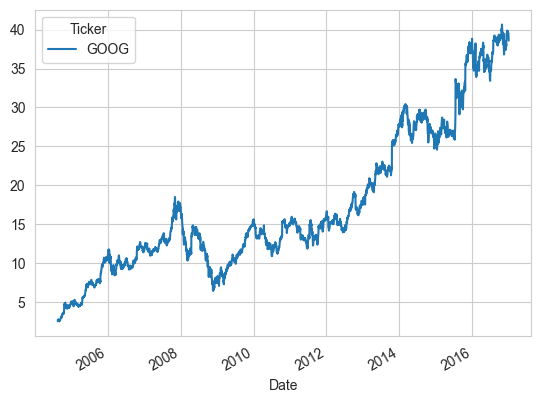

In [44]:
goog.plot();

### Remuestreo y conversión de frecuencias

Una necesidad común para los datos de series temporales es el remuestreo a una frecuencia mayor o menor.
Esto puede hacerse utilizando el método ``resample()``, o el método mucho más simple ``asfreq()``.
La principal diferencia entre ambos es que ``resample()`` es fundamentalmente una *agregación de datos*, mientras que ``asfreq()`` es fundamentalmente una *selección de datos*.

Echemos un vistazo al precio de cierre de Google y comparemos lo que nos devuelven los dos cuando reducimos el muestreo de los datos.
Aquí volveremos a muestrear los datos al final del año comercial:

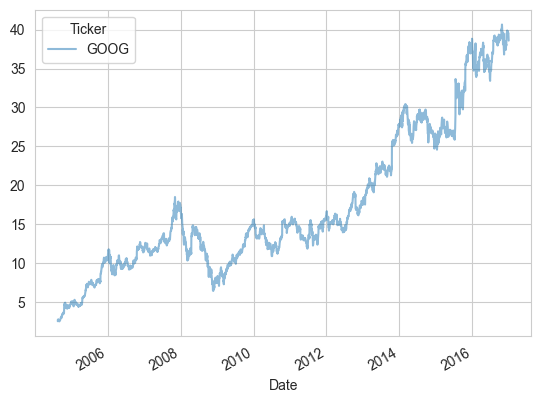

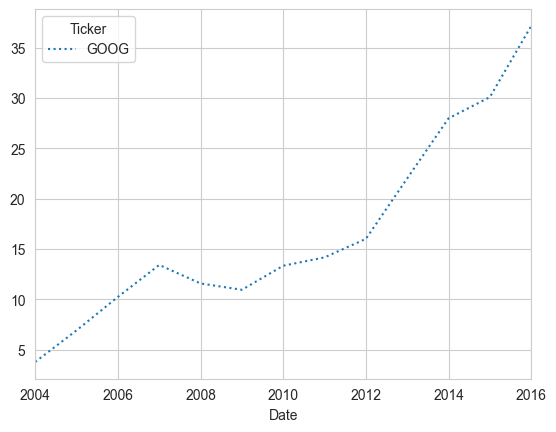

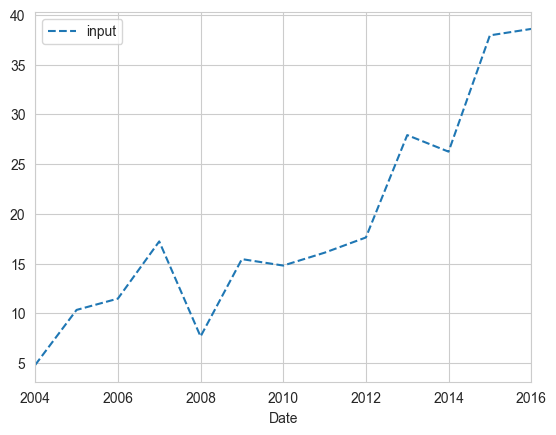

In [45]:
goog.plot(alpha=0.5, style='-')
goog.resample('BYE').mean().plot(style=':')
goog.asfreq('BYE').plot(style='--');
plt.legend(['input', 'resample', 'asfreq'],
           loc='upper left');

Fíjese en la diferencia: en cada punto, ``resample`` informa de la *media del año anterior*, mientras que ``asfreq`` informa del *valor al final del año*.

Para el muestreo ascendente, ``resample()`` y ``asfreq()`` son en gran medida equivalentes, aunque resample tiene muchas más opciones disponibles.
En este caso, el valor por defecto para ambos métodos es dejar los puntos de muestreo ascendente vacíos, es decir, llenos de valores NA.
Al igual que con la función ``pd.fillna()`` comentada anteriormente, ``asfreq()`` acepta un argumento ``method`` para especificar cómo se imputan los valores.
En este caso, volveremos a muestrear los datos de los días laborables con una frecuencia diaria (es decir, incluidos los fines de semana):

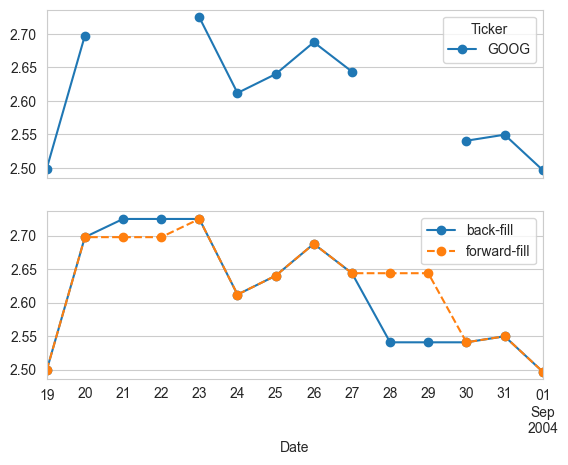

In [46]:
fig, ax = plt.subplots(2, sharex=True)
data = goog.iloc[:10]

data.asfreq('D').plot(ax=ax[0], marker='o')

data.asfreq('D', method='bfill').plot(ax=ax[1], style='-o')
data.asfreq('D', method='ffill').plot(ax=ax[1], style='--o')
ax[1].legend(["back-fill", "forward-fill"]);

El panel superior es el predeterminado: los días no laborables se dejan como valores NA y no aparecen en el gráfico.
El panel inferior muestra las diferencias entre dos estrategias para rellenar los huecos: forward-filling y backward-filling.

### Time-shifts

Otra operación común específica de las series temporales es el desplazamiento de los datos en el tiempo.
Pandas tiene dos métodos estrechamente relacionados para calcular esto: ``shift()`` y ``shift(freq='D)``.
En resumen, la diferencia entre ellos es que ``shift()`` *desplaza los datos*, mientras que ``shift(freq='D)`` *desplaza el índice*.
En ambos casos, el desplazamiento se especifica en múltiplos de la frecuencia.

Aquí desplazaremos tanto ``shift()`` como ``shift(freq='D)`` 900 días;

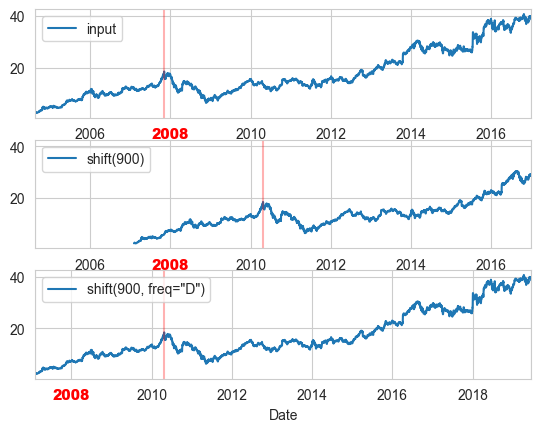

In [47]:
# Crear las subtramas
fig, ax = plt.subplots(3, sharey=True)

# Aplicar una frecuencia a los datos
goog = goog.asfreq('D', method='pad')

# Graficar los datos originales
goog.plot(ax=ax[0])
# Graficar los datos desplazados
goog.shift(900).plot(ax=ax[1])
# Desplazar el índice de tiempo y graficar
goog.shift(900, freq='D').plot(ax=ax[2])

# Leyendas y anotaciones
local_max = pd.to_datetime('2007-11-05')
offset = pd.Timedelta(900, 'D')

ax[0].legend(['input'], loc=2)
ax[0].get_xticklabels()[2].set(weight='heavy', color='red')
ax[0].axvline(local_max, alpha=0.3, color='red')

ax[1].legend(['shift(900)'], loc=2)
ax[1].get_xticklabels()[2].set(weight='heavy', color='red')
ax[1].axvline(local_max + offset, alpha=0.3, color='red')

ax[2].legend(['shift(900, freq="D")'], loc=2)
ax[2].get_xticklabels()[1].set(weight='heavy', color='red')
ax[2].axvline(local_max + offset, alpha=0.3, color='red');

plt.show()

Aquí vemos que ``shift(900)`` desplaza los *datos* 900 días, empujando parte de ellos fuera del extremo del gráfico (y dejando los valores NA en el otro extremo), mientras que ``shift(900, freq='D)`` desplaza los *valores de índice* 900 días.

Un contexto común para este tipo de desplazamiento es el cálculo de diferencias en el tiempo. Por ejemplo, utilizamos los valores desplazados para calcular el rendimiento de la inversión a un año de las acciones de Google a lo largo del conjunto de datos:

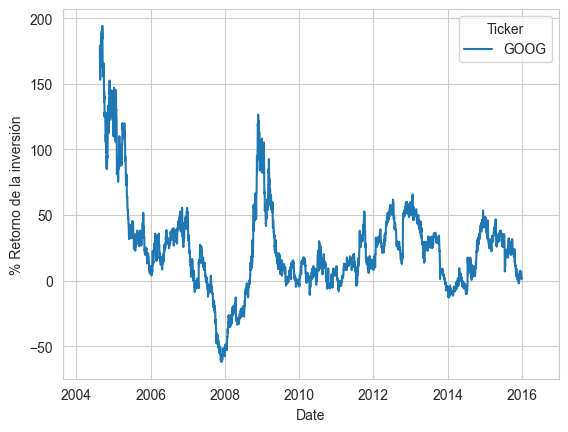

In [48]:
ROI = 100 * (goog.shift(-365, freq='D') / goog - 1)
ROI.plot()
plt.ylabel('% Retorno de la inversión');

Esto nos ayuda a ver la tendencia general de las acciones de Google: hasta ahora, los momentos más rentables para invertir en Google han sido (como era de esperar, en retrospectiva) poco después de su salida a bolsa y en plena recesión de 2009.

### Rolling windows

Las estadísticas continuas son un tercer tipo de operación específica de series temporales implementada por Pandas.
Se pueden realizar mediante el atributo ``rolling()`` de los objetos ``Series`` y ``DataFrame``, que devuelve una vista similar a la que vimos con la operación ``groupby``.
Esta ventana rodante pone a disposición una serie de operaciones de agregación por defecto.

Por ejemplo, aquí se muestra la media móvil centrada de un año y la desviación estándar de los precios de las acciones de Google:

In [49]:
rolling = goog.rolling(365, center=True)

data = pd.DataFrame({'input': goog,
                     'one-year rolling_mean': rolling.mean(),
                     'one-year rolling_std': rolling.std()})
ax = data.plot(style=['-', '--', ':'])
ax.lines[0].set_alpha(0.3)

ValueError: If using all scalar values, you must pass an index

Al igual que con las operaciones de agrupamiento, los métodos ``aggregate()`` y ``apply()`` pueden utilizarse para cálculos de balanceo personalizados.

## Ejemplo: Visualización de los recuentos de bicicletas de Seattle

Como ejemplo más complejo de trabajo con series temporales de datos, echemos un vistazo a los recuentos de bicicletas en el puente [Fremont Bridge] de Seattle.
Estos datos proceden de un contador de bicicletas automatizado, instalado a finales de 2012, que cuenta con sensores inductivos en las aceras este y oeste del puente.
Los recuentos horarios de bicicletas pueden descargarse de http://data.seattle.gov/; aquí está el [enlace directo al conjunto de datos](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k).

A partir del verano de 2016, el CSV puede descargarse de la siguiente manera:

In [ ]:
# !curl -o data/FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  559k    0  559k    0     0   212k      0 --:--:--  0:00:02 --:--:--  212k
100 1358k    0 1358k    0     0   367k      0 --:--:--  0:00:03 --:--:--  367k
100 1902k    0 1902k    0     0   398k      0 --:--:--  0:00:04 --:--:--  399k
100 2446k    0 2446k    0     0   422k      0 --:--:--  0:00:05 --:--:--  493k
100 3022k    0 3022k    0     0   452k      0 --:--:--  0:00:06 --:--:--  597k
100 3271k    0 3271k    0     0   479k      0 --:--:--  0:00:06 --:--:--  647k


Una vez descargado este conjunto de datos, podemos utilizar Pandas para leer la salida CSV en un ``DataFrame``.
Especificaremos que queremos la Fecha como índice, y queremos que estas fechas se analicen automáticamente:

In [50]:
data = pd.read_csv('data/FremontBridge.csv', index_col='Date', dtype=str)

# Convertir manualmente la columna de fechas a datetime usando to_datetime
data.index = pd.to_datetime(data.index, format="%m/%d/%Y %I:%M:%S %p")
data.head()

,"Fremont Bridge Sidewalks, south of N 34th St","Fremont Bridge Sidewalks, south of N 34th St Cyclist West Sidewalk","Fremont Bridge Sidewalks, south of N 34th St Cyclist East Sidewalk"
Date,,,
2012-10-02 13:00:00,55,7,48
2012-10-02 14:00:00,130,55,75
2012-10-02 15:00:00,152,81,71
2012-10-02 16:00:00,278,167,111
2012-10-02 17:00:00,563,393,170


Para mayor comodidad, procesaremos este conjunto de datos acortando los nombres de las columnas y añadiendo una columna "Total":

In [51]:
data.columns = ['Total', 'West', 'East']

data['Total'] = pd.to_numeric(data['Total'], errors='coerce')
data['West'] = pd.to_numeric(data['West'], errors='coerce')
data['East'] = pd.to_numeric(data['East'], errors='coerce')

data['Total'] = data.eval('West + East')

data.head()

,Total,West,East
Date,,,
2012-10-02 13:00:00,55.0,7.0,48.0
2012-10-02 14:00:00,130.0,55.0,75.0
2012-10-02 15:00:00,152.0,81.0,71.0
2012-10-02 16:00:00,278.0,167.0,111.0
2012-10-02 17:00:00,563.0,393.0,170.0


Veamos ahora las estadísticas resumidas de estos datos:

In [52]:
data.dropna().describe()

,Total,West,East
count,105116.000000,105116.000000,105116.000000
mean,106.545569,45.701967,60.843601
std,132.098939,59.570117,82.227507
min,0.000000,0.000000,0.000000
25%,13.000000,5.000000,7.000000
50%,60.000000,26.000000,32.000000
75%,146.000000,63.000000,80.000000
max,1097.000000,667.000000,850.000000


### Visualización de los datos

Podemos comprender mejor el conjunto de datos visualizándolo.
Empecemos por trazar los datos brutos:

In [53]:
import seaborn as sns
sns.set_style('whitegrid')

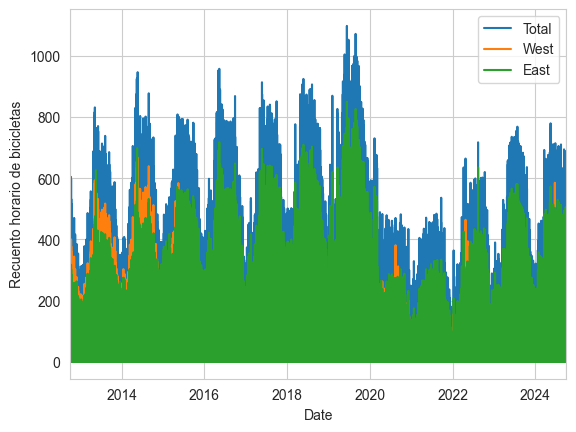

In [54]:
data.plot()
plt.ylabel('Recuento horario de bicicletas');

Las 25.000 muestras horarias son demasiado densas para que podamos entenderlas.
Podemos obtener más información volviendo a muestrear los datos en una cuadrícula más gruesa.
Hagamos un nuevo muestreo por semanas:

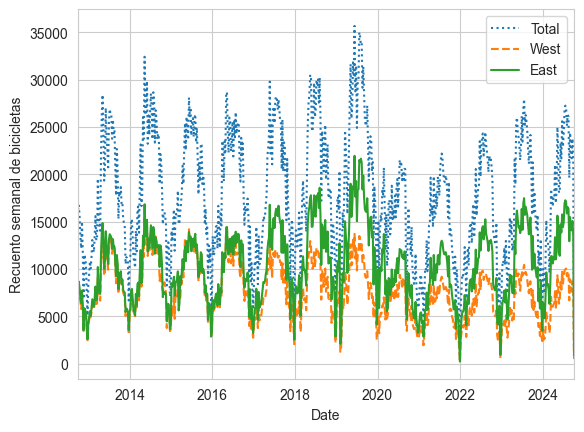

In [55]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Recuento semanal de bicicletas');

Esto nos muestra algunas tendencias estacionales interesantes: como cabría esperar, la gente va más en bicicleta en verano que en invierno, e incluso dentro de una misma estación el uso de la bicicleta varía de una semana a otra (probablemente en función del tiempo).

Otra forma útil de agregar los datos es utilizar una media móvil, utilizando la función ``pd.rolling_mean()``.
Aquí haremos una media móvil de 30 días de nuestros datos, asegurándonos de centrar la ventana:

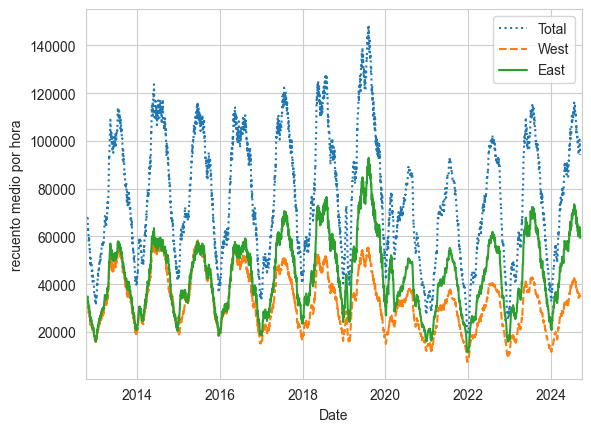

In [56]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('recuento medio por hora');

La irregularidad del resultado se debe al hard cutoff de la ventana.
Podemos obtener una versión más suave de una media móvil utilizando una función de ventana, por ejemplo, una ventana gaussiana.
El siguiente código especifica tanto la anchura de la ventana (elegimos 50 días) como la anchura de la gaussiana dentro de la ventana (elegimos 10 días):

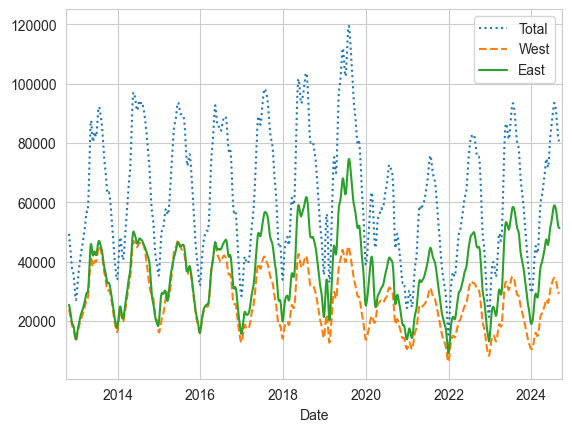

In [57]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']);

### Profundizar en los datos

Aunque estas vistas de datos suavizados son útiles para hacerse una idea de la tendencia general de los datos, ocultan gran parte de la estructura interesante.
Por ejemplo, podríamos querer ver el tráfico medio en función de la hora del día.

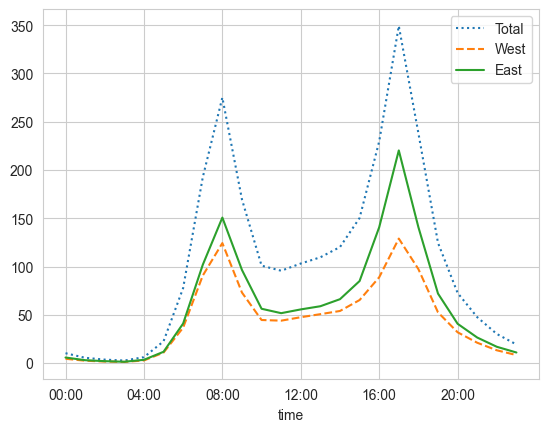

In [58]:
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

El tráfico horario presenta una distribución fuertemente bimodal, con picos en torno a las 8:00 de la mañana y las 5:00 de la tarde.
Es probable que esto evidencie un fuerte componente de tráfico de cercanías que cruza el puente.
Las diferencias entre la acera oeste (generalmente utilizada en dirección al centro de Seattle), que alcanza su punto máximo por la mañana, y la acera este (generalmente utilizada en dirección contraria al centro de Seattle), que alcanza su punto máximo por la tarde, así lo demuestran.

También nos interesa saber cómo cambian las cosas según el día de la semana. Una vez más, podemos hacerlo con una simple agrupación:

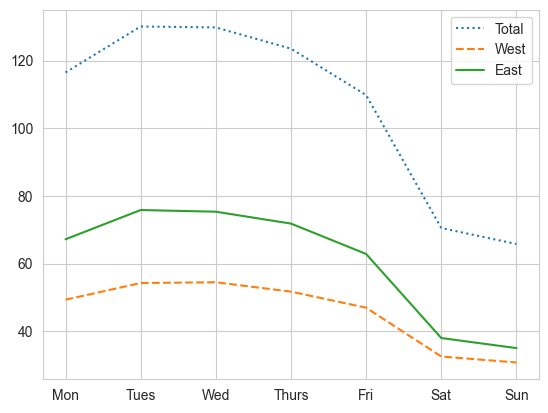

In [59]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

Esto muestra una fuerte distinción entre los totales de los días laborables y los fines de semana, con aproximadamente el doble de usuarios medios cruzando el puente de lunes a viernes que los sábados y domingos.

Teniendo esto en cuenta, hagamos un GroupBy compuesto y veamos la tendencia por hora en días laborables frente a fines de semana.
Empezaremos agrupando por la bandera que indica el fin de semana y por la hora del día:

In [60]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

Ahora usaremos algunas de las herramientas de Matplotlib para trazar dos paneles uno al lado del otro:

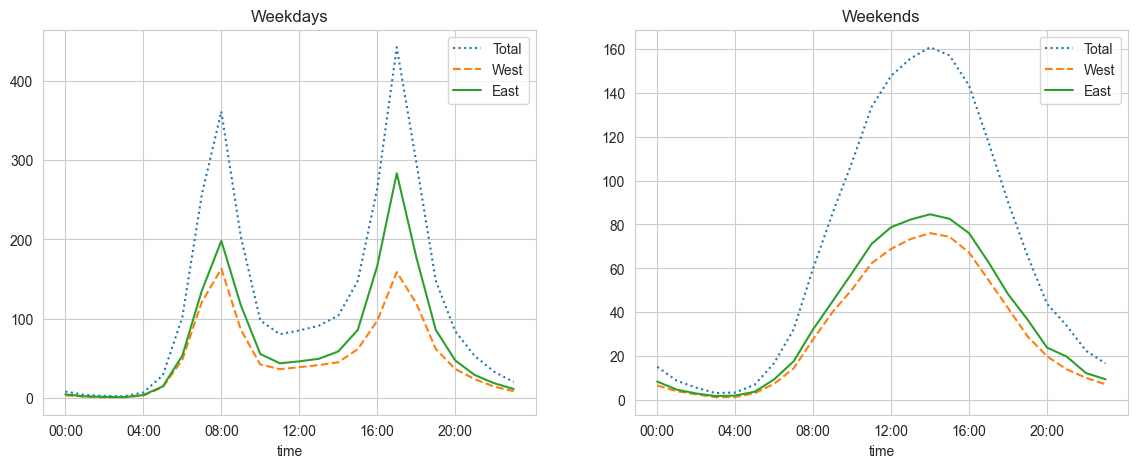

In [61]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

El resultado es muy interesante: vemos un patrón bimodal de desplazamientos durante la semana laboral, y un patrón unimodal de ocio durante los fines de semana.
Sería interesante analizar estos datos con más detalle y examinar el efecto del tiempo, la temperatura, la época del año y otros factores en las pautas de desplazamiento de la gente.

<!--NAVIGATION-->
< [Trabajar con string](9-Trabajar_con_string.ipynb) | [Eval y Query](11-Eval_y_Query.ipynb) >
